# Set-Up

In [ ]:
# Imports libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree, ensemble
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [ ]:
# Connects to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/geor2.csv') # loads csv data as pandas dataframe

In [ ]:
data # prints data

,Group,Accession,Title,Source name,Tissue,Characteristics,Gender,Smoking status,Bi,Pathological stage,...,Myc_copy,Cluster,Relapse,Days before relapse/censor,Months before relapse/censor,Death,Days before death/censor,Exclude for prognosis analysis due to incomplete resection or adjuvant therapy,Group.1,Age
0,-,GSM773540,KH024,frozen tissue of primary lung tumors,primary lung tumor,age (years): 55,female,Never-smoker,0.0,II,...,1.263,Cluster1,relapsed,253.0,8.433333,dead,437.0,exclude,NaN,NaN
1,-,GSM773541,KH081,frozen tissue of primary lung tumors,primary lung tumor,age (years): 38,female,Ever-smoker,140.0,II,...,1.064,Cluster1,relapsed,57.0,1.900000,alive,743.0,none,NaN,NaN
2,-,GSM773542,KH007,frozen tissue of primary lung tumors,primary lung tumor,age (years): 30,male,Ever-smoker,600.0,II,...,1.192,Cluster1,not relapsed,2601.0,86.700000,alive,2601.0,none,NaN,NaN
3,-,GSM773543,KH066,frozen tissue of primary lung tumors,primary lung tumor,age (years): 64,female,Never-smoker,0.0,II,...,.,Cluster1,not relapsed,1173.0,39.100000,alive,1173.0,exclude,NaN,NaN
4,-,GSM773544,KH012,frozen tissue of primary lung tumors,primary lung tumor,age (years): 63,female,Never-smoker,0.0,II,...,0.969,Cluster1,not relapsed,2369.0,78.966667,alive,2369.0,none,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-,GSM773781,KH206,Frozen normal lung tissue for KH232,normal lung,age (years): 67,male,Never-smoker,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,-,GSM773782,KH207,Frozen normal lung tissue,normal lung,NaN,male,Ever-smoker,2380.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0
243,-,GSM773783,KH208,Frozen normal lung tissue,normal lung,NaN,male,Ever-smoker,800.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0
244,-,GSM773784,KH209,Frozen normal lung tissue,normal lung,NaN,male,Ever-smoker,800.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0


In [ ]:
# X features: Gene alteration status, Characteristics, Gender, Smoking Status, Myc_copy, Bi, Pathological stage, Months before relapse/censor, Exclude for prognosis
# Y feature: Months before death/censor

In [ ]:
x0_unfiltered = list(data['Gene alteration status']) # gets gene alteration status data as a list

In [ ]:
gene_alt_dict = {"ALK-fusion +":0, "EGFR mutation +":1, "EGFR/KRAS/ALK -":2, "KRAS mutation +":3} # dictionary to convert gene alteration status to index

In [ ]:
# converts each gene alteration status into a one hot encoded vector
x0 = []
for gene_alt in x0_unfiltered:
  gene_vect = [0 for i in range(4)]
  if str(gene_alt) != "nan": gene_vect[gene_alt_dict[gene_alt]] = 1.
  x0.append(gene_vect)

In [ ]:
# gets age data
x1_unfiltered = []
mean_age = 0.
num_nonnan_ages = 0.
for s in data['Characteristics']:
  if str(s) == "nan": x1_unfiltered.append(None)
  else:
    age = int(s.replace('age (years): ', ''))
    mean_age += age
    num_nonnan_ages += 1
    x1_unfiltered.append(int(s.replace('age (years): ', '')))
mean_age /= num_nonnan_ages # gets average age

In [ ]:
# sets data where age is none to the average age
x1 = []
for ele in x1_unfiltered:
  if ele != None: x1.append(ele)
  else: x1.append(mean_age)

In [ ]:
# gets gender data (one hot encoded)
x2 = []
for gender in list(data["Gender"]):
  if gender == "male":
    x2.append([1., 0.])
  else:
    x2.append([0., 1.])

In [ ]:
# gets smoking status data (one hot encoded)
x3 = []
for status in list(data['Smoking status']):
  if status == 'Ever-smoker': x3.append([1., 0.])
  else: x3.append([0., 1.])

In [ ]:
# gets myc copy data, sets none values to mean
x4_unfiltered = []
total_mycc = 0.
n_mycc = 0.
for mycc in list(data['Myc_copy']):
  try:
    if str(mycc) != "nan":
      mycc_float = float(mycc)
      x4_unfiltered.append(mycc_float)
      total_mycc += mycc_float
      n_mycc += 1
    else: raise ValueError
  except ValueError:
    x4_unfiltered.append(None)
mean_mycc = total_mycc/n_mycc
x4 = []
for x4i in x4_unfiltered:
  if x4i != None: x4.append(x4i)
  else: x4.append(mean_mycc)

In [ ]:
# get bi data
x5 = list(map(float, list(data['Bi'])))

In [ ]:
# get pathological stage data
stages = {'IA':0, 'IB':1, 'II':2}
x6 = []
for stage in list(data['Pathological stage']):
  stage_vec = [0., 0., 0.]
  if str(stage) != "nan": stage_vec[stages[stage]] = 1.
  x6.append(stage_vec)

In [ ]:
# get months before relapse/censor
x7 = []
for relapse, months in zip(list(data['Relapse']), list(data['Months before relapse/censor'])):
  if str(relapse) == "nan" or str(months) == "nan": x7.append(0.)
  elif relapse == "not relapsed": x7.append(0.)
  else: x7.append(float(months))

In [ ]:
# get exclude for prognosis
x8 = []
for exclude in list(data['Exclude for prognosis analysis due to incomplete resection or adjuvant therapy']):
  if exclude == "exclude": x8.append([0., 1.])
  else: x8.append([1., 0.])

In [ ]:
# gets x and y data where "Days before death/censor" isn't none
y = []
x = []
for i, days in enumerate(list(data["Days before death/censor"])):
  if str(days) == "nan": continue
  y.append(float(int(float(days)/60))) # converts days before death/censor to months before death/censor
  x.append(x0[i] + [x1[i]] + x2[i] + x3[i] + [x4[i]] + [x5[i]] + x6[i] + [x7[i]] + x8[i]) # concatenates different features together

In [ ]:
# converts x and y to numpy arrays
y = np.array(y)
x = np.array(x)

In [ ]:
# shuffle x and y
x, y = shuffle(x, y, random_state=42)

In [ ]:
# # 80/10/10 split
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
# x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, shuffle=True)

# K fold
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Make heatmap

In [ ]:
from copy import deepcopy as copy

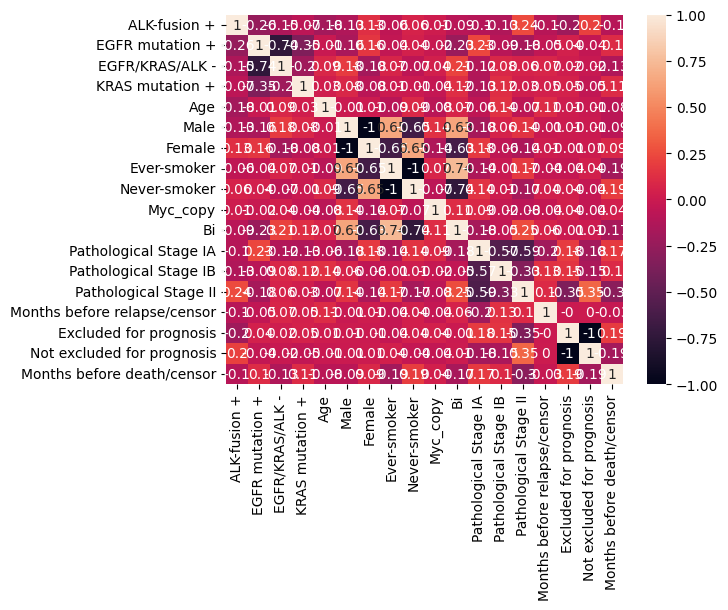

In [ ]:
columns = ["ALK-fusion +", "EGFR mutation +", "EGFR/KRAS/ALK -", "KRAS mutation +", "Age", "Male", "Female", "Ever-smoker", "Never-smoker",
           "Myc_copy", "Bi", "Pathological Stage IA", "Pathological Stage IB", "Pathological Stage II", "Months before relapse/censor", "Excluded for prognosis",
           "Not excluded for prognosis", "Months before death/censor"]
data_corr = pd.DataFrame(np.hstack([x, np.expand_dims(y,-1)]), columns=columns).corr()
labels = copy(data_corr)
for key in data_corr.keys():
  for i in range(len(data_corr[key])): labels[key][i] = round(data_corr[key][i], 2)
sns.heatmap(data_corr, annot=labels, xticklabels=data_corr.columns, yticklabels=data_corr.columns)
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

# Data Analysis

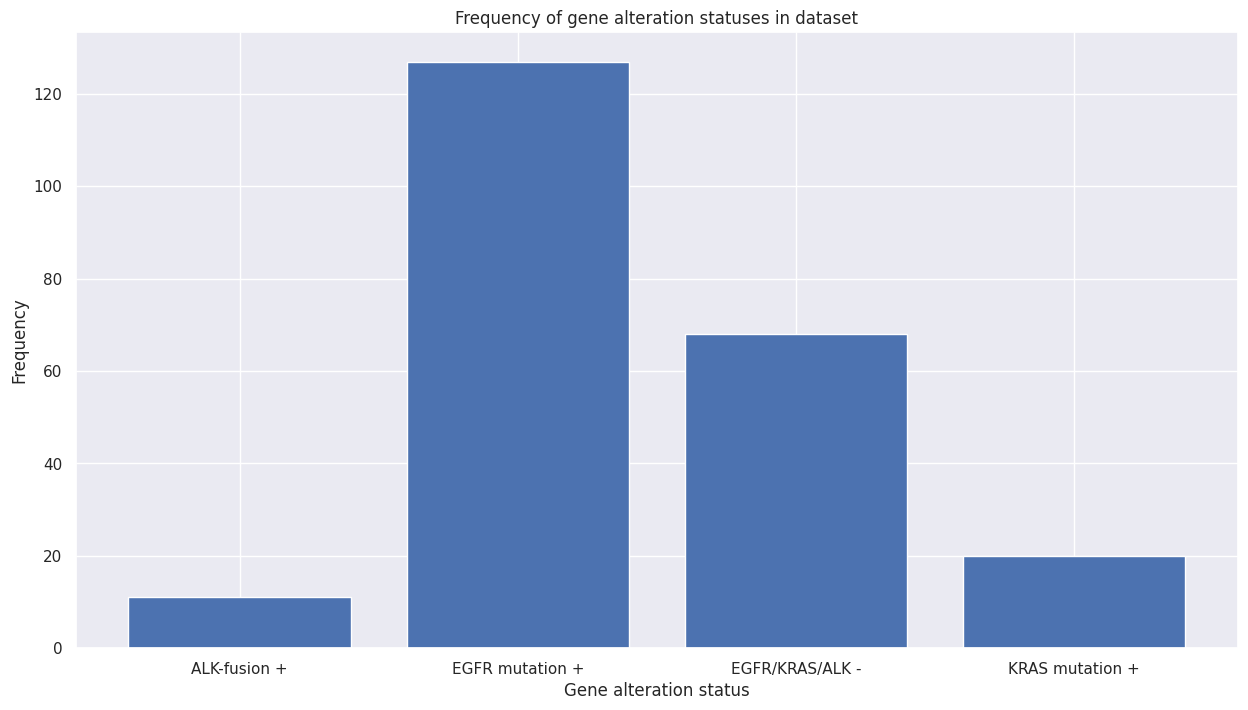

In [ ]:
# Plot gene alteration status
gas = ["ALK-fusion +", "EGFR mutation +", "EGFR/KRAS/ALK -", "KRAS mutation +"]
gas_count = [0, 0, 0, 0]
for num in list(np.argmax(x[:,:4], axis=-1)):
  gas_count[num] += 1
plt.bar(gas, gas_count)
plt.ylabel("Frequency")
plt.xlabel("Gene alteration status")
plt.title("Frequency of gene alteration statuses in dataset")
plt.show()

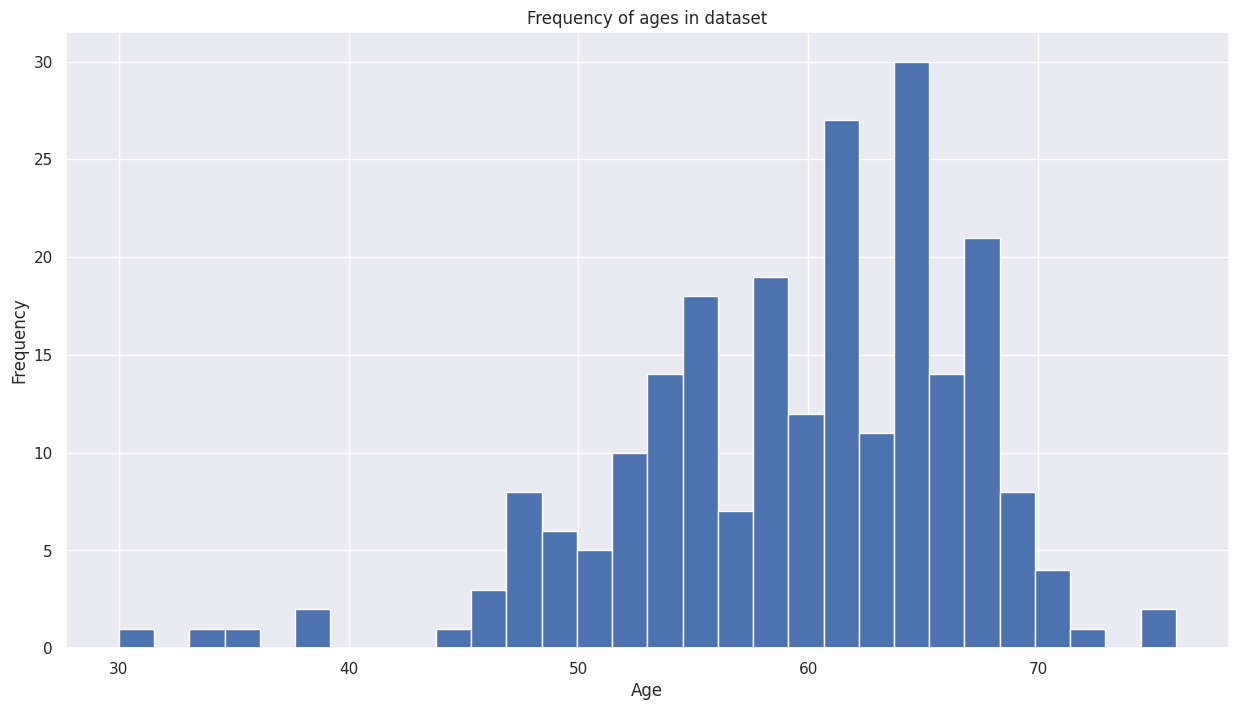

Average age: 59.57964601769911
Standard deviation of ages: 7.385427642839438


In [ ]:
# Plot age
plt.hist(x[:,4], bins=30)
plt.ylabel("Frequency")
plt.xlabel("Age")
plt.title("Frequency of ages in dataset")
plt.show()
print(f"Average age: {np.mean(x[:,4])}")
print(f"Standard deviation of ages: {np.std(x[:,4])}")

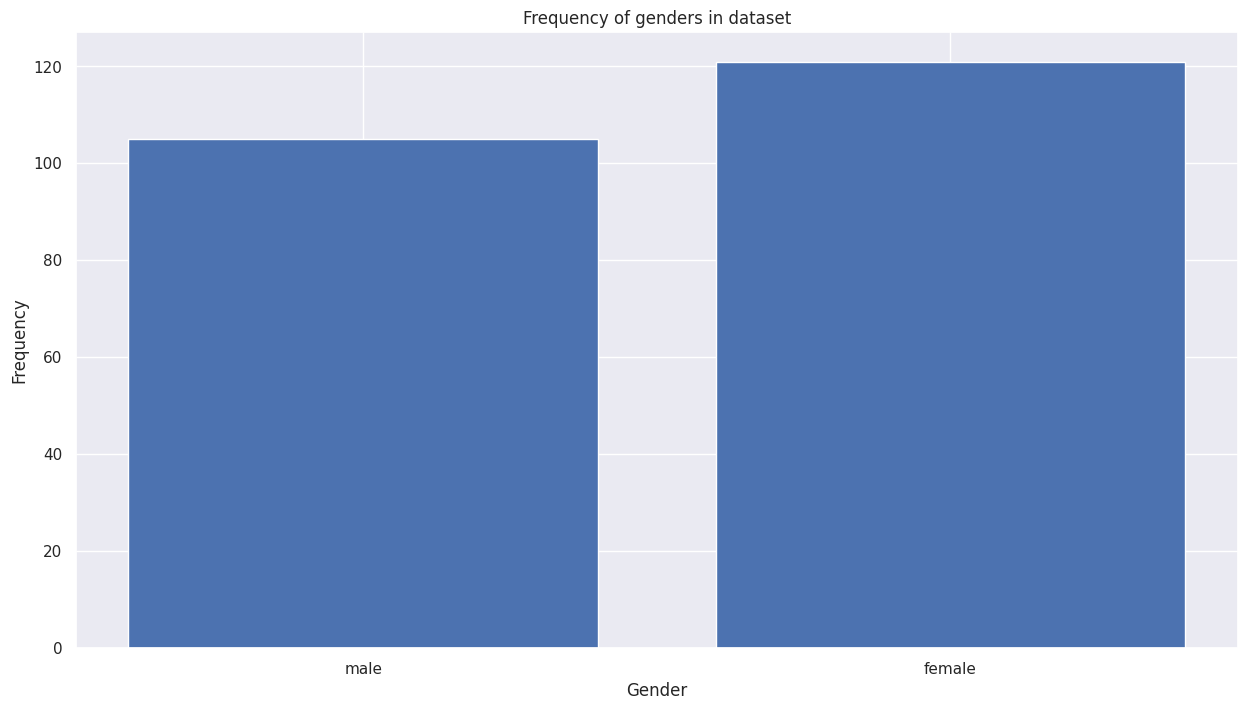

In [ ]:
# Plot gender
genders = ["male", "female"]
gender_counts = [np.sum(x[:,5]), np.sum(x[:,6])]
plt.bar(genders, gender_counts)
plt.ylabel("Frequency")
plt.xlabel("Gender")
plt.title("Frequency of genders in dataset")
plt.show()

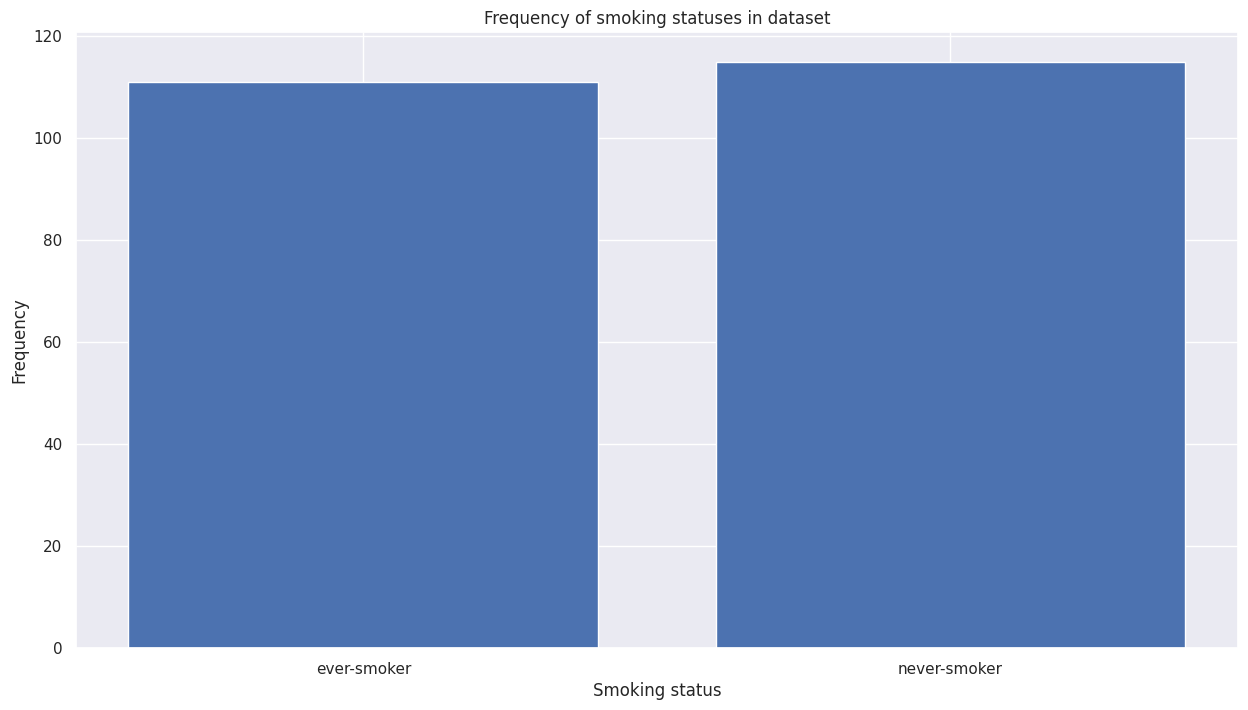

In [ ]:
# Plot smoking status
statuses = ["ever-smoker", "never-smoker"]
status_counts = [np.sum(x[:,7]), np.sum(x[:,8])]
plt.bar(statuses, status_counts)
plt.ylabel("Frequency")
plt.xlabel("Smoking status")
plt.title("Frequency of smoking statuses in dataset")
plt.show()

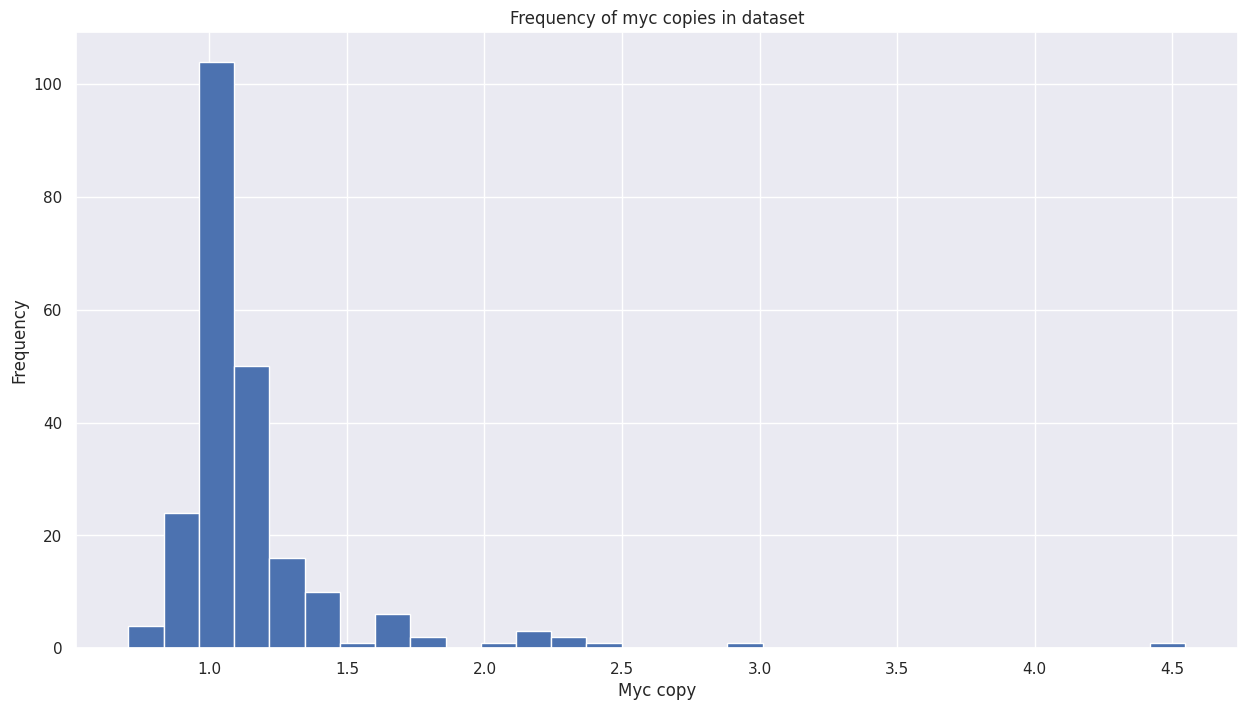

Average myc copy: 1.1591294642857144
Standard deviation of myc copy: 0.3616430135202865


In [ ]:
# Plot myc copies
plt.hist(x[:,9], bins=30)
plt.ylabel("Frequency")
plt.xlabel("Myc copy")
plt.title("Frequency of myc copies in dataset")
plt.show()
print(f"Average myc copy: {np.mean(x[:,9])}")
print(f"Standard deviation of myc copy: {np.std(x[:,9])}")

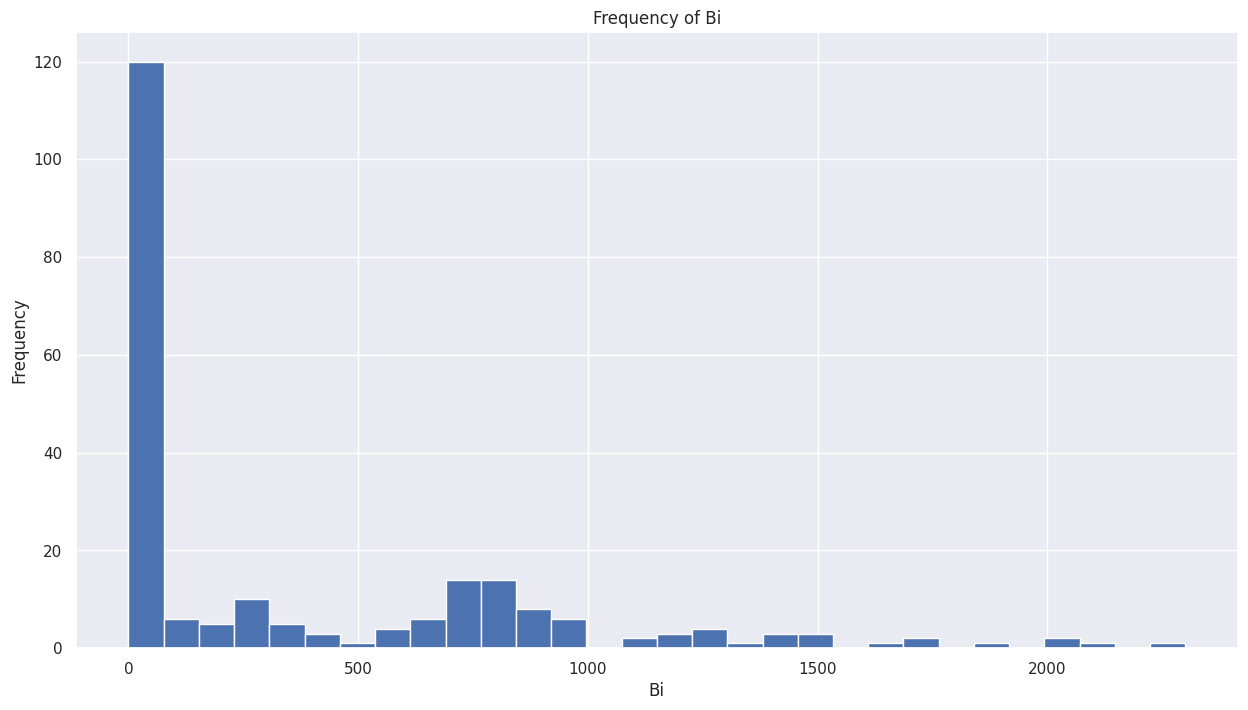

Average Bi: 374.6637168141593
Standard deviation of Bi: 515.7925444018375


In [ ]:
# Plot bi
plt.hist(x[:,10], bins=30)
plt.ylabel("Frequency")
plt.xlabel("Bi")
plt.title("Frequency of Bi")
plt.show()
print(f"Average Bi: {np.mean(x[:,10])}")
print(f"Standard deviation of Bi: {np.std(x[:,10])}")

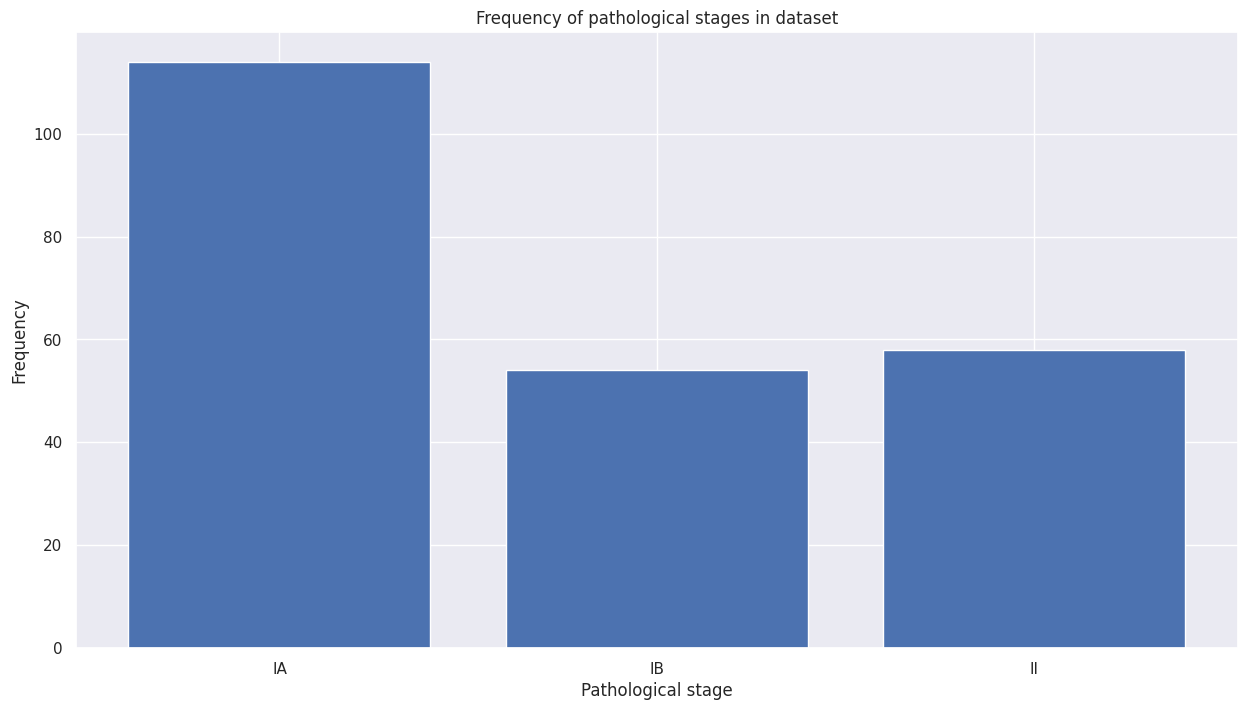

In [ ]:
# Plot Pathological stage
stages = ["IA", "IB", "II"]
stage_counts = [np.sum(x[:,11]), np.sum(x[:,12]), np.sum(x[:,13])]
plt.bar(stages, stage_counts)
plt.ylabel("Frequency")
plt.xlabel("Pathological stage")
plt.title("Frequency of pathological stages in dataset")
plt.show()

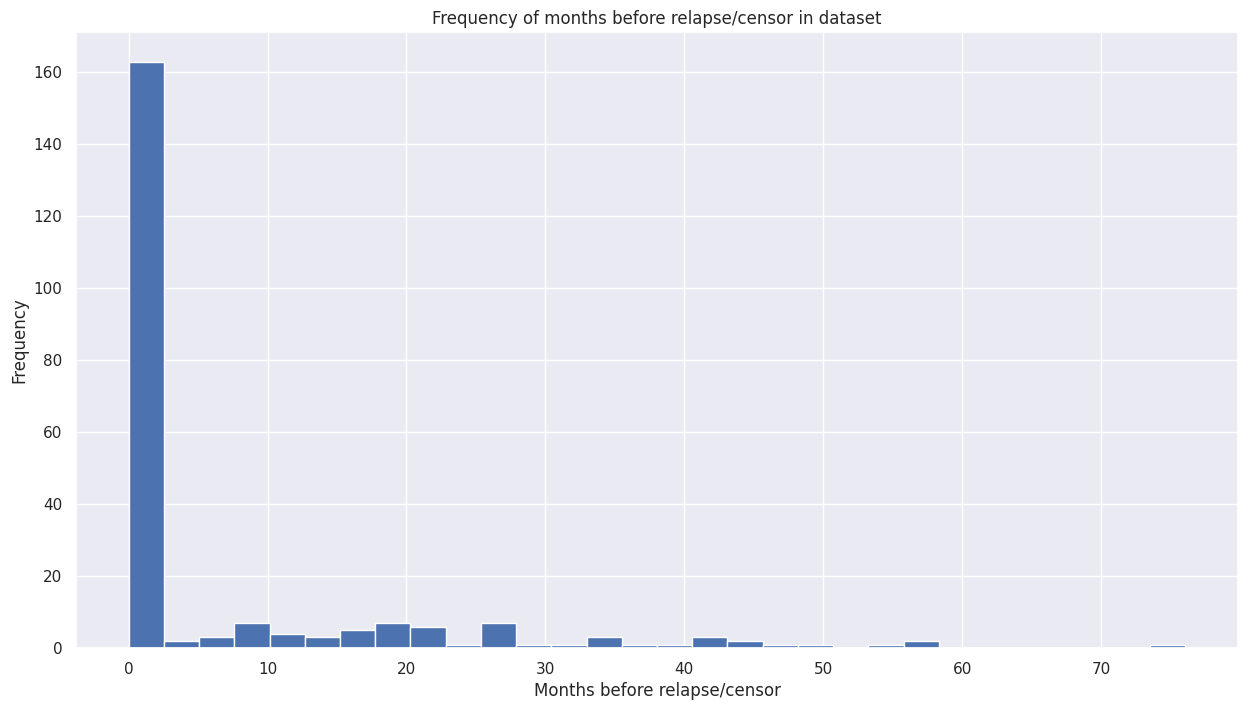

Average months before relapse/censor: 6.732448377486724
Standard deviation of months before relapse/censor: 13.48620837454435


In [ ]:
# Plot months before relapse/censor
plt.hist(x[:,14], bins=30)
plt.ylabel("Frequency")
plt.xlabel("Months before relapse/censor")
plt.title("Frequency of months before relapse/censor in dataset")
plt.show()
print(f"Average months before relapse/censor: {np.mean(x[:,14])}")
print(f"Standard deviation of months before relapse/censor: {np.std(x[:,14])}")

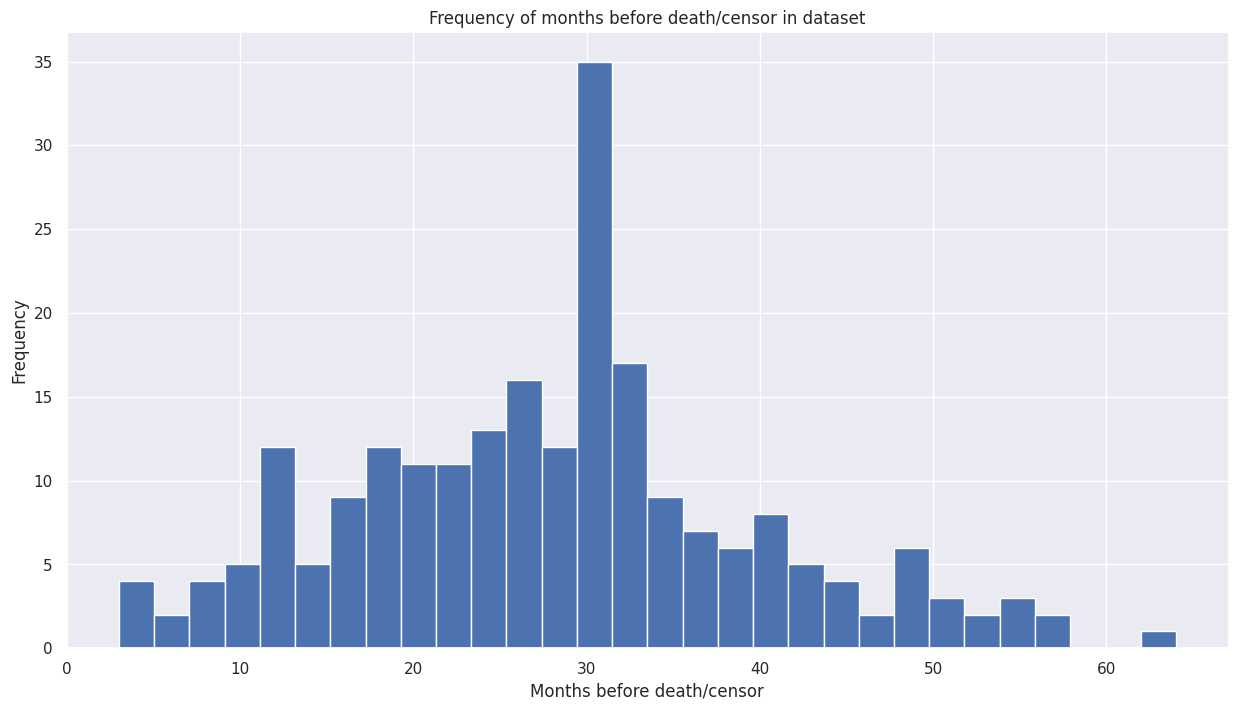

Average months before death/censor: 28.20353982300885
Standard deviation of months before death/censor: 11.454920720310163


In [ ]:
# Plot months before death/censor
plt.hist(y, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Months before death/censor")
plt.title("Frequency of months before death/censor in dataset")
plt.show()
print(f"Average months before death/censor: {np.mean(y)}")
print(f"Standard deviation of months before death/censor: {np.std(y)}")

# Train and evaluate model (PCA n components = 9)

In [ ]:
def get_error(model, x_k_val, y_k_val):
  total_diff = 0.
  n_diff = 0.
  for i in range(len(x_k_val)):
    total_diff += abs(model.predict(np.array([x_k_val[i]]))[0] - y_k_val[i])
    n_diff += 1
  return total_diff/n_diff

def kfold(make_model, params, train_model, model_name, param_name):
  df = {"Model":[], "Average error (# of months)":[]}
  for param in tqdm(params):
    df["Model"].append(f"{model_name} ({param_name}={param})")
    errors = []
    for train_idx, test_idx in kf.split(x_train):
      x_k_train, x_k_val = x_train[train_idx], x_train[test_idx]
      y_k_train, y_k_val = y_train[train_idx], y_train[test_idx]
      pca = PCA(n_components=9)
      pca.fit(x_k_train)
      x_k_train = pca.transform(x_k_train)
      x_k_val = pca.transform(x_k_val)
      model = make_model(param)
      model = train_model(model, x_k_train, y_k_train)
      errors.append(get_error(model, x_k_val, y_k_val))
    df["Average error (# of months)"].append(np.mean(errors))
  df = pd.DataFrame(df)
  return df

In [ ]:
def make_nn(num_hidden_layers):
  layers = [Input((9,))]
  for i in range(num_hidden_layers): layers.append(Dense(100, activation='relu'))
  layers.append(Dense(1, activation='relu'))
  model = Sequential(layers)
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

def train_nn(model, x_k_train, y_k_train):
  model.fit(x_k_train, y_k_train, epochs=300, batch_size=100, verbose=0)
  return model

In [ ]:
nn_df = kfold(make_nn, [i for i in range(1, 11)], train_nn, "Neural Network", "number of hidden layers")

In [ ]:
display(nn_df)

In [ ]:
def make_gbr(n_estimators):
  return GradientBoostingRegressor(n_estimators=n_estimators)

def train_gbr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
gbr_df = kfold(make_gbr, [i for i in range(1, 11)], train_gbr, "Gradient Boosting Regressor", "n_estimators")

In [ ]:
display(gbr_df)

In [ ]:
def make_svr(degree):
  return svm.SVR(degree=degree)

def train_svr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
svr_df = kfold(make_svr, [i for i in range(1, 11)], train_svr, "SVR", "degree")

In [ ]:
display(svr_df)

In [ ]:
def make_dtr(max_depth):
  return tree.DecisionTreeRegressor(max_depth=max_depth)

def train_dtr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
dtr_df = kfold(make_dtr, [i for i in range(1, 11)], train_dtr, "Decision Tree Regressor", "max_depth")

In [ ]:
display(dtr_df)

In [ ]:
def make_rfr(n_estimators):
  return ensemble.RandomForestRegressor(n_estimators=n_estimators)

def train_rfr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
rfr_df = kfold(make_rfr, [i for i in range(1, 11)], train_rfr, "Random Forest Regressor", "n_estimators")

In [ ]:
display(rfr_df)

# Train and evaluate model (PCA n components = 15)

In [ ]:
def get_error(model, x_k_val, y_k_val):
  total_diff = 0.
  n_diff = 0.
  for i in range(len(x_k_val)):
    total_diff += abs(model.predict(np.array([x_k_val[i]]))[0] - y_k_val[i])
    n_diff += 1
  return total_diff/n_diff

def kfold(make_model, params, train_model, model_name, param_name):
  df = {"Model":[], "Average error (# of months)":[]}
  for param in tqdm(params):
    df["Model"].append(f"{model_name} ({param_name}={param})")
    errors = []
    for train_idx, test_idx in kf.split(x_train):
      x_k_train, x_k_val = x_train[train_idx], x_train[test_idx]
      y_k_train, y_k_val = y_train[train_idx], y_train[test_idx]
      pca = PCA(n_components=15)
      pca.fit(x_k_train)
      x_k_train = pca.transform(x_k_train)
      x_k_val = pca.transform(x_k_val)
      model = make_model(param)
      model = train_model(model, x_k_train, y_k_train)
      errors.append(get_error(model, x_k_val, y_k_val))
    df["Average error (# of months)"].append(np.mean(errors))
  df = pd.DataFrame(df)
  return df

In [ ]:
def make_nn(num_hidden_layers):
  layers = [Input(15)]
  for i in range(num_hidden_layers): layers.append(Dense(100, activation='relu'))
  layers.append(Dense(1, activation='relu'))
  model = Sequential(layers)
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

def train_nn(model, x_k_train, y_k_train):
  model.fit(x_k_train, y_k_train, epochs=300, batch_size=100, verbose=0)
  return model

In [ ]:
nn_df = kfold(make_nn, [i for i in range(1, 11)], train_nn, "Neural Network", "number of hidden layers")

100%|██████████| 10/10 [03:13<00:00, 19.36s/it]


In [ ]:
display(nn_df)

,Model,Average error (# of months)
0,Neural Network (number of hidden layers=1),9.200817
1,Neural Network (number of hidden layers=2),8.670538
2,Neural Network (number of hidden layers=3),14.034906
3,Neural Network (number of hidden layers=4),14.530663
4,Neural Network (number of hidden layers=5),18.700550
5,Neural Network (number of hidden layers=6),18.793995
6,Neural Network (number of hidden layers=7),14.284695
7,Neural Network (number of hidden layers=8),23.596472
8,Neural Network (number of hidden layers=9),22.813957
9,Neural Network (number of hidden layers=10),17.831726


In [ ]:
def make_gbr(n_estimators):
  return GradientBoostingRegressor(n_estimators=n_estimators)

def train_gbr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
gbr_df = kfold(make_gbr, [i for i in range(1, 11)], train_gbr, "Gradient Boosting Regressor", "n_estimators")

100%|██████████| 10/10 [00:00<00:00, 17.66it/s]


In [ ]:
display(gbr_df)

,Model,Average error (# of months)
0,Gradient Boosting Regressor (n_estimators=1),8.920279
1,Gradient Boosting Regressor (n_estimators=2),8.911873
2,Gradient Boosting Regressor (n_estimators=3),8.930067
3,Gradient Boosting Regressor (n_estimators=4),8.988304
4,Gradient Boosting Regressor (n_estimators=5),8.911000
5,Gradient Boosting Regressor (n_estimators=6),8.964895
6,Gradient Boosting Regressor (n_estimators=7),8.879894
7,Gradient Boosting Regressor (n_estimators=8),8.920190
8,Gradient Boosting Regressor (n_estimators=9),8.980436
9,Gradient Boosting Regressor (n_estimators=10),8.886907


In [ ]:
def make_svr(degree):
  return svm.SVR(degree=degree)

def train_svr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
svr_df = kfold(make_svr, [i for i in range(1, 11)], train_svr, "SVR", "degree")

100%|██████████| 10/10 [00:00<00:00, 26.32it/s]


In [ ]:
display(svr_df)

,Model,Average error (# of months)
0,SVR (degree=1),8.827761
1,SVR (degree=2),8.827761
2,SVR (degree=3),8.827761
3,SVR (degree=4),8.827761
4,SVR (degree=5),8.827761
5,SVR (degree=6),8.827761
6,SVR (degree=7),8.827761
7,SVR (degree=8),8.827761
8,SVR (degree=9),8.827761
9,SVR (degree=10),8.827761


In [ ]:
def make_dtr(max_depth):
  return tree.DecisionTreeRegressor(max_depth=max_depth)

def train_dtr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
dtr_df = kfold(make_dtr, [i for i in range(1, 11)], train_dtr, "Decision Tree Regressor", "max_depth")

100%|██████████| 10/10 [00:00<00:00, 36.89it/s]


In [ ]:
display(dtr_df)

,Model,Average error (# of months)
0,Decision Tree Regressor (max_depth=1),8.839229
1,Decision Tree Regressor (max_depth=2),9.244063
2,Decision Tree Regressor (max_depth=3),9.521407
3,Decision Tree Regressor (max_depth=4),10.232108
4,Decision Tree Regressor (max_depth=5),9.765360
5,Decision Tree Regressor (max_depth=6),10.048074
6,Decision Tree Regressor (max_depth=7),10.372983
7,Decision Tree Regressor (max_depth=8),10.435357
8,Decision Tree Regressor (max_depth=9),11.291856
9,Decision Tree Regressor (max_depth=10),11.564818


In [ ]:
def make_rfr(n_estimators):
  return ensemble.RandomForestRegressor(n_estimators=n_estimators)

def train_rfr(model, x_k_train, y_k_train):
  return model.fit(x_k_train, y_k_train)

In [ ]:
rfr_df = kfold(make_rfr, [i for i in range(1, 11)], train_rfr, "Random Forest Regressor", "n_estimators")

100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


In [ ]:
display(rfr_df)

,Model,Average error (# of months)
0,Random Forest Regressor (n_estimators=1),12.572222
1,Random Forest Regressor (n_estimators=2),11.175000
2,Random Forest Regressor (n_estimators=3),10.168519
3,Random Forest Regressor (n_estimators=4),9.362500
4,Random Forest Regressor (n_estimators=5),9.731111
5,Random Forest Regressor (n_estimators=6),9.425926
6,Random Forest Regressor (n_estimators=7),9.999206
7,Random Forest Regressor (n_estimators=8),9.184722
8,Random Forest Regressor (n_estimators=9),9.362963
9,Random Forest Regressor (n_estimators=10),9.348333
